In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


path = '/Users/louis/Desktop/Tsinghua/Machine Learning/1_Project/DataSet/'
state = 'Full_Data'
full_path = path+state+'.csv'
data_set = pd.read_csv(full_path)
criteria = "Occurence"

# OR → criteria = "Percent"

# REM : f(a|b, c) means f(a) knowing b and c (e.g. with b and c fixed)

# INPUT : State & Name
# OUTPUT : Occurence = f(Year|State, Name)
def get_year(state, name, data_set_= data_set):
    return data_set_[data_set_["State"]==state][data_set_["Name"]==name]

# INPUT : Name
# OUTPUT : for each State : Occurence = f(year|State, Name)
def get_year_list(name, data_set_= data_set):
    return data_set_[data_set_["Name"]==name].pivot_table(index=["Year"],columns='State',values="Occurence")

# INPUT : Name
# OUTPUT : On average for the USA : Occurence = f(year|Name)
def get_year_USA(name, data_set_=data_set):
    if criteria=="Percent" : print("/!\ get_year_USA USES OCCURENCE, NOT PERCENT /!\ ")
    return data_set_[data_set_["Name"]==name].pivot_table(index=["Year"],columns='State',values="Occurence").sum(axis=1)

    
# INPUT : Year & Name
# OUTPUT : Occurence = f(State|Year, Name)    
def get_state(year, name, data_set_= data_set):
    return data_set_[data_set_["Year"]==year][data_set_["Name"]==name]

# INPUT : Year & State
# OUTPUT : Occurence = f(Name|Year, State)
def get_name(year, state, data_set_= data_set):
    return data_set_[data_set_["Year"]==year][data_set_["State"]==state]


# OUTPUT : List of every states in the data set
def get_list_states(data_set_ = data_set):
    return data_set["State"].drop_duplicates()


# INPUT (optional) unique = False => ith name is the most popular in the (1910+i)th year
#       (optional) period = [a,b] => only select the popular names from this period
# OUTPUT : For every year of the period, returns the most popular among the states with the number of occurences
# FORMAT : LIST
def get_list_most_used_names_year(unique = True, data_set_ = data_set):
    temp_val = data_set_.pivot_table(index="Year", columns=["Name","State"],values="Occurence").idxmax(axis=1).values
    name_list = [name for (name, state) in temp_val]
    if not unique:
        return name_list
    return [name_list[i] for i in sorted(np.unique(name_list, return_index=True)[1])]

##################################################

# >> NOT THE MOST USEFULL FUNCTIONS BELOW << 

# INPUT (optional) length = n => get the top n names. 
#       (optional) period = [a,b] => only select the popular names from this period
# OUTPUT : the most popular names among the states with the number of occurences and within the period
# FORMAT : pd.series (pandas.core.series.Series)
def get_most_used_names(length_=-1, period=(1910,2016), data_set_ = data_set):
    if criteria=="Percent" : print("/!\ get_most_used_names USES OCCURENCE, NOT PERCENT /!\ ")
    return data_set_[data_set_["Year"].isin([i for i in range(period[0],period[1]+1)])].pivot_table(index=["Year", "State"],columns='Name',values="Occurence").sum().sort_values(ascending=False)[0:length_]

# SAME AS "get_most_used_names()" but RETURNS a LIST with only the names
# FORMAT : LIST
def get_list_most_used_names(length_=-1, period=(1910,2016), data_set_ = data_set):
    return list(get_most_used_names(length_, period, data_set_).index)



In [2]:
nbr_states = 51
# hyperparameters
lr = 0.01

n_iter_training = 500
batch_size=1


n_inputs = 4   # En input on a un scalaire (qu'on regarde plusieurs fois #n_steps)
length_data = 110 # Nombre d'années qu'on a

n_steps = 50    # Années qu'on regarde
n_iter_steps = length_data - n_steps-1
n_hidden_units = 10   # A voir
n_classes = 1      # Regression !

In [3]:
list_values = get_year_list("Mary").values
import sklearn
from sklearn.preprocessing import normalize

n_inputs=51
n_classes = 51

min_val = 4

def get_xy(list_values_, n_steps_):
    x_ = np.empty((len(list_values_) - n_steps_-1, n_steps_, n_inputs), float)
    y_ = np.empty((len(list_values_) - n_steps_-1, n_steps_, n_classes), float)
    
    for i in range(len(list_values_) - n_steps_-1):
        x_[i] = list_values[i:i+n_steps_]
        y_[i] = np.transpose(np.array(list_values[i+1:i+n_steps_+1]))[0:n_classes].reshape(50, n_classes)

    return x_, y_
        
    
# list_values = np.array([[j for i in range(n_inputs)] for j in range(length_data)])
list_values = np.array(get_year_list("Mary").reindex(range(1910,2017)).fillna(min_val))
list_values = list_values/np.max(list_values, axis=0) #Normalisation
x_values, y_values = get_xy(list_values, n_steps)


## TF

In [15]:
import tensorflow as tf
tf.reset_default_graph()
r_neuron = 120    
n_windows=50
n_input=n_inputs
n_output=n_classes
n_hidden_layers=120


## 1. Construct the tensors
x = tf.placeholder(tf.float32, [1, n_windows, n_input], name="petit_x")   
y = tf.placeholder(tf.float32, [1, n_windows, n_output], name="Y")

weights = {
    'first': tf.Variable(tf.truncated_normal([n_inputs, n_hidden_layers],
                                    stddev=1./10)),
    'second': tf.Variable(tf.truncated_normal([n_hidden_layers, n_hidden_layers],
                                    stddev=1./10))
}
biases = {
    'first': tf.Variable(tf.constant(0.1, shape=[n_hidden_layers, ])),
    'second': tf.Variable(tf.constant(0.1, shape=[n_hidden_layers, ]))
}

def trans_x(X, W, b):
    X = tf.reshape(x, [-1, n_inputs])
    X_first = tf.matmul(X, weights['first']) + biases['first']
    X_second = tf.matmul(X_first, weights['second']) + biases['second']
    X_second = tf.reshape(X_second, [1, n_windows, n_hidden_layers])
    return X_second



## 2. create the model
# basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=r_neuron, activation=tf.nn.relu)   
cell = tf.nn.rnn_cell.LSTMCell(n_hidden_layers)
rnn_output, states = tf.nn.dynamic_rnn(cell, trans_x(x, W, b), dtype=tf.float32)              

stacked_rnn_output = tf.reshape(rnn_output, [-1, r_neuron])          
stacked_outputs = tf.layers.dense(stacked_rnn_output, n_output)       
outputs = tf.reshape(stacked_outputs, [-1, n_windows, n_output])   

## 3. Loss + optimization
learning_rate = 0.01  

loss = tf.reduce_sum(tf.square(outputs - y))    
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)         
training_op = optimizer.minimize(loss)   
 

In [16]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    
    
    iteration = 20 
    n_prediction = 5
    
    #TRAINING PHASE
    for i in range(iteration):
        print("###########################")
        print(i)
        print("###########################")
        for j in range(len(x_values)-n_prediction):
            batch_xs = x_values[j].reshape(-1,n_steps, n_inputs)
            batch_ys = y_values[j].reshape(-1,n_steps, n_classes)

            sess.run(training_op, feed_dict={
                x: batch_xs,
                y: batch_ys,
            })

            if i % 5 == 0:
                mse = loss.eval(feed_dict={x: batch_xs, y: batch_ys})
                print(i, "\tMSE:", mse)
    
    
    batch_xs = x_values[len(x_values)-n_prediction-1].reshape(-1,n_steps, n_inputs)
    batch_ys = y_values[len(x_values)-n_prediction-1].reshape(-1,n_steps, n_classes)
    x_pred_values = list()
    for j in range(n_prediction+1):
        
        batch_xs = sess.run(outputs, feed_dict={
            x: batch_xs,
            y: batch_ys,
        })
        x_pred_values.append(batch_xs[-1].tolist())
        



###########################
0
###########################
0 	MSE: 584.4029
0 	MSE: 1392.7637
0 	MSE: 414.8991
0 	MSE: 225.87488
0 	MSE: 191.25517
0 	MSE: 168.80896
0 	MSE: 169.26979
0 	MSE: 172.89027
0 	MSE: 161.7423
0 	MSE: 152.0829
0 	MSE: 144.90457
0 	MSE: 143.0737
0 	MSE: 144.8134
0 	MSE: 145.70815
0 	MSE: 149.87926
0 	MSE: 153.9457
0 	MSE: 162.67415
0 	MSE: 165.81308
0 	MSE: 171.62447
0 	MSE: 171.96844
0 	MSE: 174.14401
0 	MSE: 175.037
0 	MSE: 179.73267
0 	MSE: 180.33754
0 	MSE: 181.50813
0 	MSE: 185.64778
0 	MSE: 187.4772
0 	MSE: 189.62793
0 	MSE: 190.67537
0 	MSE: 189.80206
0 	MSE: 190.28944
0 	MSE: 190.65617
0 	MSE: 189.06392
0 	MSE: 185.11993
0 	MSE: 181.45639
0 	MSE: 177.85529
0 	MSE: 172.35435
0 	MSE: 163.63855
0 	MSE: 154.29468
0 	MSE: 146.63559
0 	MSE: 135.71632
0 	MSE: 127.56675
0 	MSE: 118.77039
0 	MSE: 109.36174
0 	MSE: 98.48891
0 	MSE: 88.218834
0 	MSE: 79.76752
0 	MSE: 70.88096
0 	MSE: 62.943146
0 	MSE: 56.84374
0 	MSE: 50.48351
###########################
1
#########

In [17]:
x_real_graph = np.concatenate(([val[0] for val in x_values],x_values[-1]), axis = 0)
x_pred_graph = np.concatenate((x_real_graph[0:-len(x_pred_values)],[val[-1] for val in x_pred_values]), axis=0)

x_real_graph, x_pred_graph = np.transpose(x_real_graph)[0], np.transpose(x_pred_graph)[0]

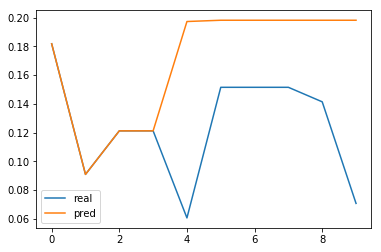

In [18]:
plt.plot(x_real_graph[-10:], label = "real")
plt.plot(x_pred_graph[-10:], label = "pred")
plt.legend()

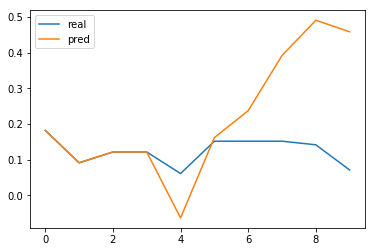

In [14]:
plt.plot(x_real_graph[-10:], label = "real")
plt.plot(x_pred_graph[-10:], label = "pred")
plt.legend()

In [ ]:
### Problème : on regarde au rang t+1 mais ça varie beaucoup trop ! Il faudrait lisser ou voir plus loin